# Topic Modeling (Prepare)

On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifying common themes in customer reviews
* Discovering the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 0: Warm-Up
* Part 1: Describe how an LDA Model works
* Part 2: Estimate a LDA Model with Gensim
* Part 3: Interpret LDA results & Select the appropriate number of topics

# Part 0: Warm-Up
How do we do a grid search? 

In [56]:
import warnings
warnings.filterwarnings("ignore")

In [57]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
# Load training data
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=('headers', 'footers', 'quotes'))

# Load testing data
newsgroups_test = fetch_20newsgroups(subset='test', 
                                     remove=('headers', 'footers', 'quotes'))

print(f'Training Samples: {len(newsgroups_train.data)}')
print(f'Testing Samples: {len(newsgroups_test.data)}')

Training Samples: 11314
Testing Samples: 7532


In [59]:
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [60]:
newsgroups_train['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [61]:
newsgroups_train['data'][1000]

"Anybody seen mouse cursor distortion running the Diamond 1024x768x256 driver?\nSorry, don't know the version of the driver (no indication in the menus) but it's a recently\ndelivered Gateway system.  Am going to try the latest drivers from Diamond BBS but wondered\nif anyone else had seen this.\n\npost or email"

### GridSearch on Just Classifier
* Fit the vectorizer and prepare BEFORE it goes into the gridsearch

In [62]:
# Instantiate vectorizer
vect = TfidfVectorizer(min_df=5)

# Transform the training data
X_train = vect.fit_transform(newsgroups_train['data'])
print(X_train.shape)

(11314, 18101)


In [63]:
params_1 = {
    'min_samples_leaf': [1, 2, 5, 10]
}

# Instantiate classifier
clf = RandomForestClassifier()

# GridSearch
gs1 = GridSearchCV(clf, params_1, cv=5, n_jobs=-1, verbose=1)
gs1.fit(X_train, newsgroups_train['target'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   44.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   46.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [64]:
gs1.best_score_

0.6407992254595025

In [65]:
gs1.best_params_

{'min_samples_leaf': 2}

In [66]:
test_sample = vect.transform(["The new york yankees are the best team in the region."])
test_sample.shape

(1, 18101)

In [67]:
gs1.predict(test_sample)[0]

9

In [68]:
newsgroups_train['target_names'][9]

'rec.sport.baseball'

### GridSearch with BOTH the Vectoizer & Classifier

In [69]:
from sklearn.pipeline import Pipeline

# 1. Create a pipeline with a vectorize and a classifier
# 2. Use Grid Search to optimize the entire pipeline
pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])

params_2 = {
    'vect__stop_words': (None, 'english'), 
    'vect__min_df': (2, 5),
    'clf__max_depth': (10, None)
}

gs2 = GridSearchCV(pipe, params_2, cv=5, n_jobs=-1, verbose=1)
gs2.fit(newsgroups_train['data'], newsgroups_train['target'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [70]:
gs2.best_score_

0.6607746264533867

In [71]:
gs2.best_params_

{'clf__max_depth': None, 'vect__min_df': 2, 'vect__stop_words': 'english'}

In [72]:
pred = gs2.predict(["The new york yankees are the best team in the region."])
pred

array([9])

In [73]:
newsgroups_train['target_names'][pred[0]]

'rec.sport.baseball'

Advantages to using GS with the Pipe:
* Allows us to make predictions on raw text increasing reproducibility. :)
* Allows us to tune the parameters of the vectorizer along side the classifier. :D 

# Part 1: Describe how an LDA Model works

[Your Guide to Latent Dirichlet Allocation](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d)

[LDA Topic Modeling](https://lettier.com/projects/lda-topic-modeling/)

[Topic Modeling with Gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [74]:
# Download spacy model
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [75]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
df = pd.DataFrame({
    'content': newsgroups_train['data'],
    'target': newsgroups_train['target'],
    'target_names': [newsgroups_train['target_names'][i] for i in newsgroups_train['target']]
})
print(df.shape)

(11314, 3)


In [77]:
pd.set_option('display.max_colwidth', 0)
df.sample(3)

,content,target,target_names
1600,"Kermit Tensmeyer quoted from a few sources and then wrote something.\nI will attempt to construct a facsimile of what was previously said, and \nthen address Kermit's offering.\n\nJohn Redelfs originally wrote...\n\n jr> I learned that a man cannot frustrate justice by repenting on his\n jr> death bed because repentance is more than a feeling of remorse. It\n jr> requires faith in Christ proven by following him, by keeping his\n jr> commandments. Such cannot be accomplished on ones deathbed.\n\nTom Albrecht responded...\n\n ta> So Jesus must have lied to the thief on the cross.\n\nJohn Redelfs wrote back that...\n\n jr> Paradise and salvation are not the same thing. Salvation is better.\n jr> Refer to John 14:2.\n\nI responded to John that...\n\n rw> I don't see the effort to equate salvation with paradise.\n rw>\n rw> Rather, I see implied the fact that only those who are saved\n rw> may enter paradise.\n\nTo which Kermit wrote...\n\nkt> Incomplete reference:\nkt>\nkt> See also the discussion: Did Jesus go into Hell in the BibleStudy group\nkt> for the arguments that Paradise and Hell(sheol) are places after death\nkt> The discussion (no LDS were involved as far as I could see) argued using\nkt> standard Christian argument from the Bible that pretty much support the\nkt> LDS position.\nkt>\nkt> Christ went to paridise after his death and burial.\nkt>\nkt> He taught the prisoners and freed them from Darkness.\nkt>\nkt> When he was resurrected, he had not yet ascended to his father.\nkt>\nkt> The arguement centered around what was or wasn't the proper biblical\nkt> terms for those places.\n\n I respond.\n\n The question that was raised was not if Jesus went to infernal Paradise\n before entering into heaven. No one has made a point for or against \n that issue, nor have they compared the LDS position against orthodox\n belief. The infernal paradise is held to be Abraham's bosom (Luke 16), \n the place of the righteous dead in sheol (equivalent to hades).\n\n The point that was raised by John was that someone could not repent\n on their death bed. Tom Albrecht pointed to a Biblical example that was\n contradictory to what John's position put forward. The thief on the \n cross was promised by Christ to be with Him in Paradise, the abode of \n the righteous dead. John's position possibly needs to be reworked.\n Kermit needs to address the topic at hand.",19,talk.religion.misc
3463,"\nBryan Murray has done very little as GM...Yzerman, Fedorov, Cheveldae,\nChaisson, the whole Russian strategy was a product of the previous\nGM...Murray has made a couple of decent trades...that's about it...\nthat would hardly rank him as the best GM.\n\nWasn't Primeau, Murray's first decision as GM...",10,rec.sport.hockey
2874,"Hi everyone, \n\t I'm a commited Christian that is battling with a problem. I know\nthat romans talks about how we are saved by our faith not our deeds, yet\nhebrews and james say that faith without deeds is useless, saying' You fools,\ndo you still think that just believing is enough?'\n\nNow if someone is fully believing but there life is totally lead by themselves\nand not by God, according to Romans that person is still saved by there faith.\nBut then there is the bit which says that God preferes someone who is cold to\nhim (i.e. doesn't know him - condemned) so a lukewarm Christian someone who\nknows and believes in God but doesn't make any attempt to live by the bible.\n\nNow I am of the opinion that you a saved through faith alone (not what you do)\nas taught in Romans, but how can I square up in my mind the teachings of James\nin conjunction with the lukewarm Christian being 'spat-out'\n\nCan anyone help me, this really bothers me.\n\nIn Christ,\nWill\n",15,soc.religion.christian


In [78]:
' '.join("  The apple has         fallen from the tree.  ".split())

'The apple has fallen from the tree.'

In [79]:
# For reference on regex: https://docs.python.org/3/library/re.html
# From 'content' column: 

# 1. Remove new line characters
df['clean_text'] = df['content'].apply(lambda x: re.sub('\s+', ' ', x))

# 2. Remove Emails
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('From: \S+@\S+', '', x))

# 3. Remove non-alphanumeric characters
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# 4. Remove extra whitespace 
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(x.split()))

In [80]:
df.sample(3)

,content,target,target_names,clean_text
453,"\nOf course posting some hard evidence or facts is much more\ndifficult. You have not bothered to substantiate this in\nany way. Basil, do you know of any evidence that would support\nthis?\n\nI can just imagine a news report from ancient times, if Hasan\nhad been writing it.\n\nNewsflash:\nCairo AP (Ancient Press). Israel today denied Egypt acces to the Red\nSea. In a typical display of Israelite agressiveness, the leader of\nthe Israelite slave revolt, former prince Moses, parted the Red Sea.\nThe action is estimated to have caused irreparable damage to the environment.\nEgyptian authorities have said that thousands of fisherman have been\ndenied their livelihood by the parted waters. Pharaoh's brave charioteers\nwere successful in their glorious attempt to cause the waters of the\nRed Sea to return to their normal state. Unfortunately they suffered\nheavy casualties while doing so.\n\n",17,talk.politics.mideast,Of course posting some hard evidence or facts is much more difficult You have not bothered to substantiate this in any way Basil do you know of any evidence that would support this I can just imagine a news report from ancient times if Hasan had been writing it Newsflash Cairo AP Ancient Press Israel today denied Egypt acces to the Red Sea In a typical display of Israelite agressiveness the leader of the Israelite slave revolt former prince Moses parted the Red Sea The action is estimated to have caused irreparable damage to the environment Egyptian authorities have said that thousands of fisherman have been denied their livelihood by the parted waters Pharaoh s brave charioteers were successful in their glorious attempt to cause the waters of the Red Sea to return to their normal state Unfortunately they suffered heavy casualties while doing so
4206,I wanted to let people know that this motorcycle has been sold.\n\nThanks for your inquiries.,8,rec.motorcycles,I wanted to let people know that this motorcycle has been sold Thanks for your inquiries
6503,"I was on vacation all last week and didn't see any news at all. Could\nsomebody fill me in on how St. Louis ended up with Mark Whiten in a \ntrade? Who did we give up Arocha, Allen Watson, Dmitri Young, or did\nDal make a decent deal?\n\n:\n",9,rec.sport.baseball,I was on vacation all last week and didn t see any news at all Could somebody fill me in on how St Louis ended up with Mark Whiten in a trade Who did we give up Arocha Allen Watson Dmitri Young or did Dal make a decent deal


In [81]:
nlp = spacy.load("en_core_web_lg")

In [82]:
# Leverage tqdm for progress_apply
from tqdm import tqdm
tqdm.pandas()

# If you're on macOS, Linux, or python session executed from Windows Subsystem for Linux (WSL)
# conda activate U4-S1-NLP
# pip install pandarallel
#
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)
#
# df['lemmas'] = df['content'].parallel_apply(get_lemmas)
#
# Ref: https://github.com/nalepae/pandarallel

In [85]:
# Create 'lemmas' column
def get_lemmas(x):
    lemmas = []
    for token in nlp(x):
        if (token.is_stop!=True) and (token.is_punct!=True):
            lemmas.append(token.lemma_)
    return lemmas

df['lemmas'] = df['clean_text'].progress_apply(get_lemmas)

100%|███████████████████████████████████████████████| 11314/11314 [12:49<00:00, 14.71it/s]


In [86]:
df.head()

,content,target,target_names,clean_text,lemmas
0,"I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.",7,rec.autos,I was wondering if anyone out there could enlighten me on this car I saw the other day It was a door sports car looked to be from the late s early s It was called a Bricklin The doors were really small In addition the front bumper was separate from the rest of the body This is all I know If anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please e mail,"[wonder, enlighten, car, see, day, door, sport, car, look, late, s, early, s, call, Bricklin, door, small, addition, bumper, separate, rest, body, know, tellme, model, engine, spec, year, production, car, history, info, funky, look, car, e, mail]"
1,"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.",4,comp.sys.mac.hardware,A fair number of brave souls who upgraded their SI clock oscillator have shared their experiences for this poll Please send a brief message detailing your experiences with the procedure Top speed attained CPU rated speed add on cards and adapters heat sinks hour of usage per day floppy disk functionality with and m floppies are especially requested I will be summarizing in the next two days so please add to the network knowledge base if you have done the clock upgrade and haven t answered this poll Thanks,"[fair, number, brave, soul, upgrade, SI, clock, oscillator, share, experience, poll, send, brief, message, detail, experience, procedure, speed, attain, CPU, rate, speed, add, card, adapter, heat, sink, hour, usage, day, floppy, disk, functionality, m, floppy, especially, request, summarize, day, add, network, knowledge, base, clock, upgrade, haven, t, answer, poll, thank]"
2,"well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected? i'd heard the 185c was supposed to make an\nappearence ""this summer"" but haven't heard anymore on it - and since i\ndon't have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo's just went through recently?\n\n* what's the impression of the display on the 180? i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don't really have\na feel for how much ""better"" the display is (yea, it looks great in the\nstore, but is that all ""wow"" or is it really that good?). could i solicit\nsome opinions of people who use the 160 and 180 day-to-day on if its worth\ntaking the disk size and money hit to get the active display? (i realize\nthis is a real subjective question, but i've only played around with the\nmachines in a comput

### The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus.

In [87]:
# Create Dictionary
id2word = corpora.Dictionary(df['lemmas'])

In [88]:
# How many words do we have?
len(id2word.keys())

78702

In [89]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=3, no_above=0.75)

In [90]:
# How many words do we have?
len(id2word.keys())

22810

In [91]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

In [92]:
id2word[109]

'hear'

In [93]:
df.iloc[5]['clean_text']

'Of course The term must be rigidly defined in any bill I doubt she uses this term for that You are using a quote allegedly from her can you back it up I read the article as presenting first an argument about weapons of mass destruction as commonly understood and then switching to other topics The first point evidently was to show that not all weapons should be allowed and then the later analysis was given this understanding to consider another class'

In [94]:
corpus[5]

[(105, 1),
 (162, 1),
 (179, 1),
 (205, 1),
 (209, 1),
 (210, 1),
 (211, 1),
 (212, 1),
 (213, 1),
 (214, 1),
 (215, 1),
 (216, 1),
 (217, 1),
 (218, 1),
 (219, 1),
 (220, 1),
 (221, 1),
 (222, 1),
 (223, 1),
 (224, 1),
 (225, 1),
 (226, 1),
 (227, 1),
 (228, 1),
 (229, 2),
 (230, 1),
 (231, 1),
 (232, 2)]

In [95]:
id2word[105]

'give'

In [96]:
id2word[232]

'weapon'

In [97]:
# Human readable format of corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[5]]

[('give', 1),
 ('use', 1),
 ('article', 1),
 ('understanding', 1),
 ('allegedly', 1),
 ('allow', 1),
 ('analysis', 1),
 ('argument', 1),
 ('bill', 1),
 ('class', 1),
 ('commonly', 1),
 ('consider', 1),
 ('course', 1),
 ('define', 1),
 ('destruction', 1),
 ('doubt', 1),
 ('evidently', 1),
 ('later', 1),
 ('mass', 1),
 ('point', 1),
 ('present', 1),
 ('quote', 1),
 ('read', 1),
 ('switch', 1),
 ('term', 2),
 ('topic', 1),
 ('understand', 1),
 ('weapon', 2)]

# Part 2: Estimate a LDA Model with Gensim

 ### Train an LDA model

In [98]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20, 
                                            chunksize=100,
                                            passes=10,
                                            per_word_topics=True)

# https://radimrehurek.com/gensim/models/ldamodel.html

Wall time: 3min 25s


In [99]:
lda_model.save('lda_model.model')

In [100]:
from gensim import models
lda =  models.LdaModel.load('lda_model.model')

### View the topics in LDA model

In [101]:
# View the top 10 words per topic
pprint(lda.print_topics())

[(0,
  '0.207*"v" + 0.127*"B" + 0.111*"z" + 0.104*"g" + 0.084*"b" + 0.079*"f" + '
  '0.041*"r" + 0.034*"MR" + 0.018*"G" + 0.013*"d"'),
 (1,
  '0.041*"edu" + 0.031*"thank" + 0.030*"com" + 0.029*"mail" + 0.022*"e" + '
  '0.021*"new" + 0.019*"offer" + 0.019*"send" + 0.018*"price" + 0.018*"post"'),
 (2,
  '0.408*"y" + 0.069*"kid" + 0.052*"doctor" + 0.044*"cop" + 0.036*"South" + '
  '0.020*"diet" + 0.013*"partner" + 0.009*"wash" + 0.008*"till" + '
  '0.004*"declaration"'),
 (3,
  '0.037*"key" + 0.021*"s" + 0.020*"public" + 0.015*"patient" + 0.013*"group" '
  '+ 0.010*"S" + 0.010*"issue" + 0.009*"message" + 0.009*"year" + '
  '0.009*"government"'),
 (4,
  '0.050*"Israel" + 0.032*"list" + 0.032*"copy" + 0.028*"send" + 0.018*"day" + '
  '0.017*"event" + 0.017*"package" + 0.017*"receive" + 0.016*"request" + '
  '0.014*"address"'),
 (5,
  '0.206*"c" + 0.161*"C" + 0.142*"o" + 0.069*"H" + 0.060*"w" + 0.038*"D" + '
  '0.036*"k" + 0.030*"HP" + 0.017*"default" + 0.016*"Mail"'),
 (6,
  '0.103*"drive" 

In [102]:
# Extract Document-Topic distributions for each document in corpus
doc_lda = lda[corpus]
doc_lda[0][0]

[(1, 0.20056535),
 (7, 0.30486175),
 (12, 0.176513),
 (13, 0.16696738),
 (16, 0.064020984),
 (18, 0.06706466)]

In [103]:
doc_lda[5][0]

[(6, 0.037423767), (8, 0.19632193), (10, 0.366388), (15, 0.37319547)]

### What is topic Perplexity?
Perplexity is a statistical measure of how well a probability model predicts a sample. As applied to LDA, for a given value of , you estimate the LDA model. Then given the theoretical word distributions represented by the topics, compare that to the actual topic mixtures, or distribution of words in your documents.

### What is topic coherence?
Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.
A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

In [104]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, 
                                     texts=df['lemmas'], 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.25614937314385

Coherence Score:  0.5449053934648151


# Part 3: Interpret LDA results & Select the appropriate number of topics

In [112]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, id2word, mds='mmds')
pyLDAvis.display(vis)

In [106]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=12)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [107]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=df['lemmas'], 
                                                        start=10, 
                                                        limit=41, 
                                                        step=5)

Wall time: 10min 29s


In [108]:
# coherence_values = [0.5054, 0.5332, 0.5452, 0.564, 0.5678, 0.5518, 0.519]

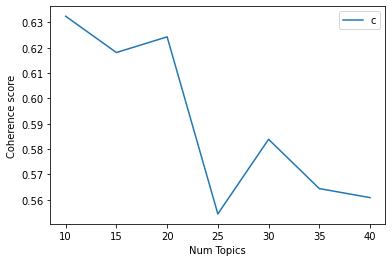

In [109]:
start=10; limit=41; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [110]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.6324
Num Topics = 15  has Coherence Value of 0.6181
Num Topics = 20  has Coherence Value of 0.6243
Num Topics = 25  has Coherence Value of 0.5544
Num Topics = 30  has Coherence Value of 0.5839
Num Topics = 35  has Coherence Value of 0.5644
Num Topics = 40  has Coherence Value of 0.5609


In [111]:
# Select the model and print the topics
# optimal_model = model_list[4]
# optimal_model =  models.LdaModel.load('optimal_model.model')
# model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))